In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data as dt
import torchvision.transforms as transforms
import time
import os
import random
from PIL import Image
from dataset import AutoDataset
from networks import AutoEncoder

In [ ]:
batch = 64
epoch = 30
lr = 0.0001

In [2]:
#function converts one folder of pictures into
def autoencoder_dataset(path, set_percent = 0.1):
    transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize((0.5), (0.5/3))])   #Make sure images are tensors, lie within 0 and 1
    dataset = AutoDataset(path, transform = transform) #need to implement   #Turn the images into a dataset
    set_size = int( set_percent * len( dataset ) )                                                        #Length of test and validation sets
    return dt.random_split(dataset, [len( dataset ) - 2 * set_size, set_size, set_size])                #Return datasets in order of training set, validation set, test setde

In [3]:
train, val, test = autoencoder_dataset('Data\Hilbert\Autoencoder')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
train_loader = dt.DataLoader(train, batch_size = 64)
val_loader = dt.DataLoader(val, batch_size = 64)
test_loader = dt.DataLoader(test, batch_size = 64)

In [6]:
def get_accuracy(model, loader, criterion, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    model = model.cuda()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, picture in enumerate(loader, 0):
        picture = picture.cuda()
        outputs = model(picture)
        loss = criterion(outputs, picture)
        corr = torch.sum(torch.eq(picture, outputs))
        #total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(picture)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1) /batch_size
    return err, loss

In [7]:
def pathy(epoch, batch_size, lr):
    model_path = os.path.join('Data','Training', f'epoch_{epoch}_batch{batch_size}_lr{lr}')
    return model_path

In [8]:
def train_auto(net, batch_size = 64, lr = 0.01, epoch = 30):
    net = net.cuda()
    random.seed(1000)
    np.random.seed(1000)
    torch.manual_seed(1000)
    torch.cuda.manual_seed(1000)
    
    criterion = nn.MSELoss() #since we used 2 classes instead of 1. 
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    train_err = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)
    
    start_time = time.time()
    
    for epoch in range(epoch):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, picture in enumerate(train_loader):
            
            picture = picture.cuda()
            #print(picture.shape)
            
            optimizer.zero_grad()
            outputs = net(picture)
            loss = criterion(outputs, picture)
    
            loss.backward()
            optimizer.step()

            corr = torch.sum(torch.eq(picture, outputs))
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(picture)
        
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) /  (i+1) / batch_size
        val_err[epoch], val_loss[epoch] = get_accuracy(net, val_loader, criterion, batch_size)
        print(("Epoch {}: Train loss: {} | "+
                "Validation loss: {}").format(
                   epoch + 1,
                   train_loss[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = pathy(epoch, batch_size, lr)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    #print(net.state_dict())
    
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    return criterion

In [9]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [10]:
auto = AutoEncoder()
crit = train_auto(auto, batch_size=64, lr = 0.0005)

Epoch 1: Train loss: 0.05689590097311385 | Validation loss: 0.033278213019407754
Epoch 2: Train loss: 0.02708328724603331 | Validation loss: 0.024573028626105796
Epoch 3: Train loss: 0.024341111387758296 | Validation loss: 0.024438300739391156
Epoch 4: Train loss: 0.024313284629365293 | Validation loss: 0.024438216443663525
Epoch 5: Train loss: 0.024313492223992723 | Validation loss: 0.02443786278826083
Epoch 6: Train loss: 0.024313609210518342 | Validation loss: 0.02443774560051507
Epoch 7: Train loss: 0.024313642242829194 | Validation loss: 0.02443772066225655
Epoch 8: Train loss: 0.024313649126084202 | Validation loss: 0.024437715648121743
Epoch 9: Train loss: 0.024313650358244468 | Validation loss: 0.024437714668246808
Epoch 10: Train loss: 0.02431365059204466 | Validation loss: 0.024437714315138723
Epoch 11: Train loss: 0.024313650670716763 | Validation loss: 0.024437714315138723
Epoch 12: Train loss: 0.024313650664068417 | Validation loss: 0.024437714315138723
Epoch 13: Train los

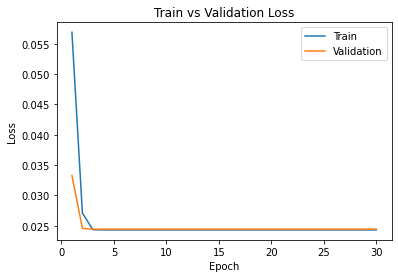

In [11]:
plot_training_curve(pathy(epoch=29, batch_size=64, lr = 0.001))

In [14]:
torch.save(auto.state_dict(), os.path.join('Model', f'epoch{29}_batch{64}_lr{0.001}.pth'))